# Forecasting CPI with Machine Learning: Data Preparation

## Import libraries

In [1]:
# Data Manipulation Libraries
import pandas as pd 
import numpy as np
from numpy.random import seed # for reproducible results
seed(1)
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import shap
import tensorflow as tf
from tensorflow import keras

In [2]:
print(sys.version)
print(
    pd.__version__,
    np.__version__,
    tf.__version__
)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
1.5.2 1.23.5 2.8.2


## Helper Functions

In [3]:
def build_nn(architecture, input_shape, lr=0.001, l2=0.1):
    
    
    """
    Builds a net according to specified architecture and activation function.
    
    Parameters 
    ----------
    architecture: an iterable containing the number of units in each layer. The length of the iterable determines the number of layers to add.
    activation: the activation function to use for each hidden_layer, 'elu' by default.
    
    Returns
    ----------
    model: a keras model object.
    """
    
    model = keras.models.Sequential()
    
    model.add(keras.Input(shape=input_shape))
    batch_standardize = False         
    
    n_layers = len(architecture)
    if n_layers >= 2:
        batch_standardize=True # for nets with two or more layers we apply batch normalization to avoid exploding/vanishing gradients
        
    for units in architecture:
        model.add(keras.layers.Dense(units, 
                                     activation='elu', 
                                     kernel_initializer='he_normal',
                                     kernel_regularizer=keras.regularizers.l2(l2)
                                     ))
        if batch_standardize:
            model.add(keras.layers.BatchNormalization())
        
            
    model.add(keras.layers.Dense(1, activation='linear'))
        
    optimizer=keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])
    
    return model


def build_multitask_nn(hardsharing_architecture, taskspecific_architectures, ntasks, tasknames, input_shape, lr=0.001, l2=0.1):

    """
    Builds a multitask nn.

    Parameters
    ----------
    hardsharing_architecture: the architecture for the hardsharing layers (iterable).
    taskspecific_architectures: the architecture for each task specific group of layers (iterable of iterables).
    ntasks: The number of tasks.
    tasknames: tasknames
    input_shape: input shape
    """

    # Hard-sharing layers
    batchnorm = False

    inlayer = keras.layers.Input(shape=input_shape, name='input')

    n_layers = len(hardsharing_architecture)

    # Create hardsharing layers
    if n_layers >= 2:
        batchnorm=True # for nets with two or more layers we apply batch normalization to avoid exploding/vanishing gradients

    hardsharing_layers = [ keras.layers.Dense(nodes, activation='elu', 
                                                kernel_initializer='he_normal', 
                                                kernel_regularizer=keras.regularizers.l2(l2)) for nodes in hardsharing_architecture]
    
    if batchnorm:
        hardsharing_layers = [ (keras.layers.Dense(nodes, activation='elu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(l2)), keras.layers.BatchNormalization()) for nodes in hardsharing_architecture ]
        
        hardsharing_layers = [x for tup in hardsharing_layers for x in tup]

    hardsharing = keras.models.Sequential(hardsharing_layers)(inlayer)
      

    # Task-specific layers
    batchnorm = False

    outputs = []
    for i in range(ntasks):
        taskarch = taskspecific_architectures[i] 

        # Create task-specific layer
        if len(taskarch) >= 2:
            batchnorm = True

        tasklayers = [ keras.layers.Dense(nodes, activation='elu', 
                                                kernel_initializer='he_normal', 
                                                kernel_regularizer=keras.regularizers.l2(l2)) for nodes in taskarch]

        if batchnorm:
            tasklayers = [ (keras.layers.Dense(nodes, activation='elu', 
                                                kernel_initializer='he_normal', 
                                                kernel_regularizer=keras.regularizers.l2(l2)), keras.layers.BatchNormalization()) for nodes in taskarch]
            tasklayers = [x for tup in tasklayers for x in tup]
            
        # Add output layer
        tasklayers.append(keras.layers.Dense(1, activation='linear'))

        # Create task-specific net
        tasknet = keras.models.Sequential(tasklayers, name=tasknames[i])(hardsharing)

        # Append task-specific net to outputs list
        outputs.append(tasknet)

    # Create and compile full model
    model = keras.models.Model(inputs=inlayer, outputs=outputs)
    optimizer=keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999)
    model.compile(loss=['mse']*6, optimizer=optimizer, metrics = ['mae','mape'])

    return model

def mc_shapley_value_par(estimator, feature_index, instance_index, X, n_iters, n_jobs=-1):
    
    """
    Estimates shapley value of feature feature_index for instance under the estimator provided.
    
    Parameters
    ----------
    estimator: a trained keras multi-task neural network.
    feature_index: a feature index in [0, n_features-1].
    instance_index: the row index of the instance of interest in df set X. 
    X: dataframe of feature values.
    num_samples: the number of monte carlo iterations
    
    Returns
    ----------
    shapley_value: a monte carlo estimate of the Shapley value for the feature and instance of interest.
    ci_95: a 95% confidence interval for the Shapley value estimate.
    
    See Strumbelji and Kononenko (2014). Explanining prediction models and individual predictions with feature contributions.
        knowledge and information systems, 41(3):647-665.
    """
    
    from joblib import delayed, Parallel
    
    # define the instance shape (ncol,)
    x = X.iloc[instance_index].values 
    
    n_features = len(X.columns)
    
    feature_indicies = [i for i in range(n_features)]

    # Generates n_iters MC estimates of the marginal contribution of a feature. 

    # initialize shapley value to 0
    shapley_value = np.zeros((6,))
    
    def create_coalitions():
         
        # select at random a permutation of indicies shape (ncols,)
        o = np.random.permutation(feature_indicies) 
        
        # Select at random another instance shape (ncols,)
        w = X.sample().values.reshape(-1,)
        
        x_j = x[feature_index] 
        w_j = w[feature_index]
        
        # construct two new instances
        
        preceeding_j_in_o = o[0:feature_index]
        succeeding_j_in_o = o[feature_index+1:-1]
        
        b1 = np.concatenate(
            [
                np.array(x[:feature_index]), # preceeding j in o from x
                np.array([x_j]), # j from x
                np.array(w[feature_index+1:]) # suceeding j in o from w
            ]
        )
        
        b2 = np.concatenate(
            [
                np.array(x[:feature_index]), # preceeding j in o from x
                np.array([w_j]), # j from w
                np.array(w[feature_index+1:]) # suceeding j in o from w
            ]
        )
        
        return b1, b2
    
    # Returns a list of tuples (b1, b2)
    results = Parallel(n_jobs=n_jobs)(delayed(create_coalitions)() for i in range(n_iters))
    
    b1s, b2s = zip(*results)
    
    b1_arr = np.stack(b1s, axis=0)
    b2_arr = np.stack(b2s, axis=0)
    
    # Make predictions and reshape to (targets, iterations) from (targets, iterations, 1)
    b1_preds = np.array(estimator.predict( b1_arr ))[:,:,0]
    b2_preds = np.array(estimator.predict( b2_arr ))[:,:,0]
    
    marginal_contributions = b1_preds - b2_preds
    
    # take the mean across iterations
    shapley_value = np.mean(marginal_contributions, axis=1)
    
    return shapley_value


## Prepare Data

In [2]:
# data_path = 'FRED-MD_2023-01.csv'
data_path = 'C:/Users/Robpr/OneDrive/Documents/Data/FactorTiming/FredMcCrackenNgMonthly.csv'
fred_y = pd.read_csv('FRED-MD_2023-01.csv').iloc[1:]
fred = pd.read_csv(data_path)
fred = fred.iloc[1:]

In [3]:
fred_y['date'] = pd.date_range('1959-01-01', '2022-12-01', freq='MS')
fred_y.drop('sasdate', axis=1, inplace=True)
fred_y.set_index('date', inplace=True)
fred['date'] = pd.to_datetime(fred['date'], format='%Y-%m-%d')
fred.set_index('date', inplace=True)

In [4]:
start_date = '1960-01-01'
fred = fred.loc[start_date:]
fred_y = fred_y.loc[start_date:fred.index[-1]]

In [5]:
(fred.isna().sum() / fred.shape[0]).sort_values(ascending=False).head(10)

ACOGNO           0.518767
UMCSENTx         0.290885
TWEXAFEGSMTHx    0.210456
ANDENOx          0.131367
VIXCLSx          0.040214
S&P PE ratio     0.005362
CP3Mx            0.002681
S&P div yield    0.002681
ISRATIOx         0.001340
CONSPI           0.001340
dtype: float64

In [6]:
X = fred.dropna(thresh=0.99*fred.shape[0],axis=1)

### Construct feature and target data frames

In [7]:
fred_y.shape

(746, 127)

In [8]:
X.shape

(746, 122)

<AxesSubplot: xlabel='date'>

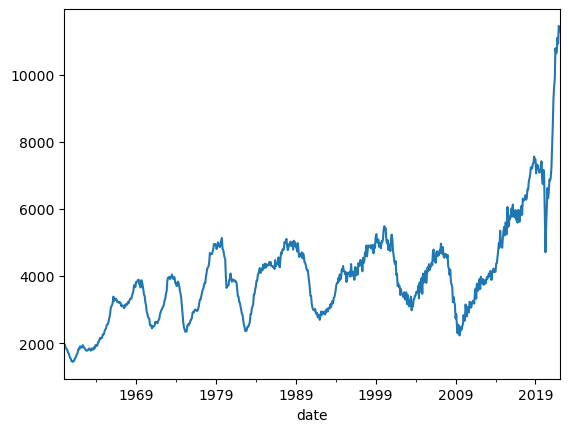

In [30]:
fred_y['HWI'].plot()

In [31]:
# y = pd.DataFrame(
#     {
#         'delta_cpi_1mo': np.log(fred_y['CPIAUCSL'].shift(-1)) - np.log(fred_y['CPIAUCSL']),
#         'delta_cpi_3mo': np.log(fred_y['CPIAUCSL'].shift(-3)) - np.log(fred_y['CPIAUCSL']),
#         'delta_cpi_6mo': np.log(fred_y['CPIAUCSL'].shift(-6)) - np.log(fred_y['CPIAUCSL']),
#         'delta_cpi_12mo': np.log(fred_y['CPIAUCSL'].shift(-12)) - np.log(fred_y['CPIAUCSL']),
#         'delta_cpi_24mo': np.log(fred_y['CPIAUCSL'].shift(-24)) - np.log(fred_y['CPIAUCSL']),
#     }
# )

infl_t = np.log(fred_y['CPIAUCSL']) - np.log(fred_y['CPIAUCSL'].shift(1)) #pi_t = log(P_t) - log(P_{t-1})
unrate_t = fred_y['UNRATE'] / 100
delta_unrate_t = unrate_t - unrate_t.shift(1)
delta_hwi_t = np.log(fred_y['HWI']) - np.log(fred_y['HWI'].shift(1))

y = pd.DataFrame()
y_delta_unrate = pd.DataFrame()
y_unrate = pd.DataFrame()
y_delta_hwi = pd.DataFrame()
for h in range(1, 12+1):
    y['infl_tp'+str(h)] = infl_t.shift(-h) # pi_{t+h}
    y_unrate['unrate_tp' + str(h)] = unrate_t.shift(-h)
    y_delta_unrate['unrate_tp' + str(h)] = delta_unrate_t.shift(-h)
    y_delta_hwi['delta_hwi_tp' + str(h)] = delta_hwi_t.shift(-h)
y.tail(30)

,infl_tp1,infl_tp2,infl_tp3,infl_tp4,infl_tp5,infl_tp6,infl_tp7,infl_tp8,infl_tp9,infl_tp10,infl_tp11,infl_tp12
date,,,,,,,,,,,,
2019-09-01,0.002759,0.001875,0.001841,0.001621,0.001256,-0.003256,-0.008054,-0.000586,0.004961,0.005142,0.004003,0.002347
2019-10-01,0.001875,0.001841,0.001621,0.001256,-0.003256,-0.008054,-0.000586,0.004961,0.005142,0.004003,0.002347,0.000622
2019-11-01,0.001841,0.001621,0.001256,-0.003256,-0.008054,-0.000586,0.004961,0.005142,0.004003,0.002347,0.000622,0.001416
2019-12-01,0.001621,0.001256,-0.003256,-0.008054,-0.000586,0.004961,0.005142,0.004003,0.002347,0.000622,0.001416,0.003228
2020-01-01,0.001256,-0.003256,-0.008054,-0.000586,0.004961,0.005142,0.004003,0.002347,0.000622,0.001416,0.003228,0.002429
2020-02-01,-0.003256,-0.008054,-0.000586,0.004961,0.005142,0.004003,0.002347,0.000622,0.001416,0.003228,0.002429,0.004361
2020-03-01,-0.008054,-0.000586,0.004961,0.005142,0.004003,0.002347,0.000622,0.001416,0.003228,0.002429,0.004361,0.006367
2020-04-01,-0.000586,0.004961,0.005142,0.004003,0.002347,0.000622,0.001416,0.003228,0.002429,0.004361,0.006367,0.006390
2020-05-01,0.004961,0.005142,0.004003,0.002347,0.000622,0.001416,0.003228,0.002429,0.004361,0.006367,0.006390,0.006994


In [33]:
y_delta_hwi.head()

,delta_hwi_tp1,delta_hwi_tp2,delta_hwi_tp3,delta_hwi_tp4,delta_hwi_tp5,delta_hwi_tp6,delta_hwi_tp7,delta_hwi_tp8,delta_hwi_tp9,delta_hwi_tp10,delta_hwi_tp11,delta_hwi_tp12
date,,,,,,,,,,,,
1960-01-01,0.000000,-0.044613,-0.021449,-0.012544,-0.022198,-0.037158,-0.012306,-0.039079,-0.041947,-0.015464,-0.048563,0.000681
1960-02-01,-0.044613,-0.021449,-0.012544,-0.022198,-0.037158,-0.012306,-0.039079,-0.041947,-0.015464,-0.048563,0.000681,-0.017177
1960-03-01,-0.021449,-0.012544,-0.022198,-0.037158,-0.012306,-0.039079,-0.041947,-0.015464,-0.048563,0.000681,-0.017177,0.020577
1960-04-01,-0.012544,-0.022198,-0.037158,-0.012306,-0.039079,-0.041947,-0.015464,-0.048563,0.000681,-0.017177,0.020577,0.002035
1960-05-01,-0.022198,-0.037158,-0.012306,-0.039079,-0.041947,-0.015464,-0.048563,0.000681,-0.017177,0.020577,0.002035,0.043096


<AxesSubplot: xlabel='date'>

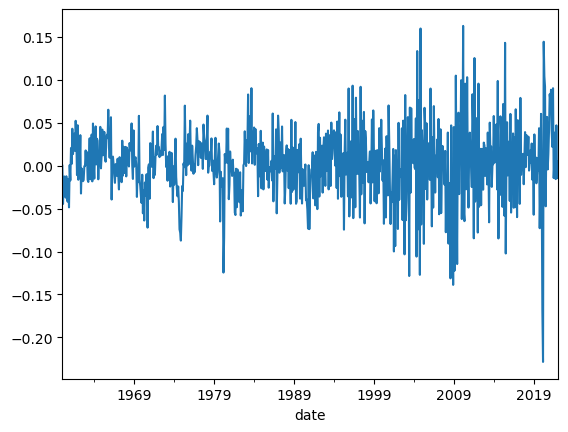

In [34]:
y_delta_hwi['delta_hwi_tp1'].plot()

In [35]:
# y_unrate.to_csv('unrate.csv')
# y_delta_unrate.to_csv('delta_unrate.csv')
y_delta_hwi.to_csv('delta_hwi.csv')

In [101]:
y.head(30)

,infl_tp1,infl_tp2,infl_tp3,infl_tp4,infl_tp5,infl_tp6,infl_tp7,infl_tp8,infl_tp9,infl_tp10,infl_tp11,infl_tp12
date,,,,,,,,,,,,
1960-01-01,0.001361,0.000000,0.004411,0.001015,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006
1960-02-01,0.000000,0.004411,0.001015,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000
1960-03-01,0.004411,0.001015,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000
1960-04-01,0.001015,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006
1960-05-01,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006
1960-06-01,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000
1960-07-01,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000,0.002677
1960-08-01,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000,0.002677,0.000668
1960-09-01,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000,0.002677,0.000668,0.001335


In [102]:
y = y.loc[:'2020-12-01']
X = X.loc[y.index] # To match y
print(X.shape, y.shape)

(732, 122) (732, 12)


In [103]:
X_shifted = X.apply(lambda col: col.shift(1)).dropna() # Account for announcement delays
y = y.loc[X_shifted.index]

In [105]:
X_shifted.to_csv('inflfc_features.csv')
y.to_csv('inflfc_targets.csv')

In [154]:
6*122

732

In [107]:
5*12

60

In [109]:
X_lags = X_shifted.copy()
cols = X_lags.columns
for col in cols:
    for lag in (1,3,6,9,12):
        X_lags[col + '_tm' + str(lag)] = X_lags[col].shift(lag)

X_lags.head(30)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DTCTHFNM_tm1,DTCTHFNM_tm3,DTCTHFNM_tm6,DTCTHFNM_tm9,DTCTHFNM_tm12,INVEST_tm1,INVEST_tm3,INVEST_tm6,INVEST_tm9,INVEST_tm12
date,,,,,,,,,,,,,,,,,,,,,
1960-02-01,0.003194,0.004638,0.002788,0.016956,0.026606,0.025917,0.024097,0.029020,0.031234,0.103833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,0.001143,0.000917,0.004335,0.014371,0.003696,-0.008937,-0.005686,-0.003437,-0.011454,-0.013859,...,-0.011739,NaN,NaN,NaN,NaN,-0.013330,NaN,NaN,NaN,NaN
1960-04-01,0.001909,0.000916,0.014041,-0.028026,-0.001102,-0.009018,-0.003425,-0.001150,0.001152,-0.019965,...,0.005388,NaN,NaN,NaN,NaN,-0.018942,NaN,NaN,NaN,NaN
1960-05-01,0.003419,0.003614,0.015355,0.009826,0.025903,-0.007962,0.002285,0.001150,0.006879,-0.001188,...,0.000951,-0.011739,NaN,NaN,NaN,0.003490,-0.013330,NaN,NaN,NaN
1960-06-01,0.002401,0.002443,-0.020343,-0.031531,-0.015047,-0.001141,0.005693,0.006865,0.005699,0.009461,...,0.005452,0.005388,NaN,NaN,NaN,0.024136,-0.018942,NaN,NaN,NaN
1960-07-01,0.000789,-0.000248,-0.000220,0.008586,-0.001364,-0.012651,-0.011414,-0.011467,-0.006843,-0.010645,...,-0.002067,0.000951,NaN,NaN,NaN,0.003798,0.003490,NaN,NaN,NaN
1960-08-01,0.001829,0.001901,0.002032,-0.006856,-0.010099,-0.003476,-0.005758,-0.005788,-0.009194,-0.038796,...,0.007420,0.005452,-0.011739,NaN,NaN,-0.009981,0.024136,-0.013330,NaN,NaN
1960-09-01,-0.001627,-0.002563,-0.000988,-0.001246,0.003414,-0.001166,-0.002315,0.000000,0.002307,0.011064,...,-0.003291,-0.002067,0.005388,NaN,NaN,0.032176,0.003798,-0.018942,NaN,NaN
1960-10-01,0.001273,0.000290,0.004765,0.016061,-0.000935,-0.010518,-0.008135,-0.005813,-0.004620,-0.012301,...,-0.002301,0.007420,0.000951,NaN,NaN,-0.024113,-0.009981,0.003490,NaN,NaN


In [149]:
X_lags4 = X_shifted.copy()
cols = X_lags4.columns
for col in cols:
    for lag in range(1,4+1):
        X_lags4[col + '_tm' + str(lag)] = X_lags4[col].shift(lag)

X_lags4.head(30)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DTCOLNVHFNM_tm3,DTCOLNVHFNM_tm4,DTCTHFNM_tm1,DTCTHFNM_tm2,DTCTHFNM_tm3,DTCTHFNM_tm4,INVEST_tm1,INVEST_tm2,INVEST_tm3,INVEST_tm4
date,,,,,,,,,,,,,,,,,,,,,
1960-02-01,0.003194,0.004638,0.002788,0.016956,0.026606,0.025917,0.024097,0.029020,0.031234,0.103833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,0.001143,0.000917,0.004335,0.014371,0.003696,-0.008937,-0.005686,-0.003437,-0.011454,-0.013859,...,NaN,NaN,-0.011739,NaN,NaN,NaN,-0.013330,NaN,NaN,NaN
1960-04-01,0.001909,0.000916,0.014041,-0.028026,-0.001102,-0.009018,-0.003425,-0.001150,0.001152,-0.019965,...,NaN,NaN,0.005388,-0.011739,NaN,NaN,-0.018942,-0.013330,NaN,NaN
1960-05-01,0.003419,0.003614,0.015355,0.009826,0.025903,-0.007962,0.002285,0.001150,0.006879,-0.001188,...,0.004292,NaN,0.000951,0.005388,-0.011739,NaN,0.003490,-0.018942,-0.013330,NaN
1960-06-01,0.002401,0.002443,-0.020343,-0.031531,-0.015047,-0.001141,0.005693,0.006865,0.005699,0.009461,...,0.008268,0.004292,0.005452,0.000951,0.005388,-0.011739,0.024136,0.003490,-0.018942,-0.013330
1960-07-01,0.000789,-0.000248,-0.000220,0.008586,-0.001364,-0.012651,-0.011414,-0.011467,-0.006843,-0.010645,...,0.003472,0.008268,-0.002067,0.005452,0.000951,0.005388,0.003798,0.024136,0.003490,-0.018942
1960-08-01,0.001829,0.001901,0.002032,-0.006856,-0.010099,-0.003476,-0.005758,-0.005788,-0.009194,-0.038796,...,0.008678,0.003472,0.007420,-0.002067,0.005452,0.000951,-0.009981,0.003798,0.024136,0.003490
1960-09-01,-0.001627,-0.002563,-0.000988,-0.001246,0.003414,-0.001166,-0.002315,0.000000,0.002307,0.011064,...,-0.004827,0.008678,-0.003291,0.007420,-0.002067,0.005452,0.032176,-0.009981,0.003798,0.024136
1960-10-01,0.001273,0.000290,0.004765,0.016061,-0.000935,-0.010518,-0.008135,-0.005813,-0.004620,-0.012301,...,0.005126,-0.004827,-0.002301,-0.003291,0.007420,-0.002067,-0.024113,0.032176,-0.009981,0.003798


In [145]:
ar_terms = pd.DataFrame()
ar_terms_unrate = pd.DataFrame()
y_cols = y.columns
for lag in range(12+1):
    # no need for inflation at time t because CPI is already differenced
    ar_terms['infl_tm' + str(lag)] = infl_t.shift(lag)
    ar_terms_unrate['unrate_tm' + str(lag)] = unrate_t.shift()
 
ar_terms.head(20)

,infl_tm0,infl_tm1,infl_tm2,infl_tm3,infl_tm4,infl_tm5,infl_tm6,infl_tm7,infl_tm8,infl_tm9,infl_tm10,infl_tm11,infl_tm12
date,,,,,,,,,,,,,
1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,0.001361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,0.000000,0.001361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04-01,0.004411,0.000000,0.001361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05-01,0.001015,0.004411,0.000000,0.001361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-06-01,0.001352,0.001015,0.004411,0.000000,0.001361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-07-01,-0.002028,0.001352,0.001015,0.004411,0.000000,0.001361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-08-01,0.002028,-0.002028,0.001352,0.001015,0.004411,0.000000,0.001361,NaN,NaN,NaN,NaN,NaN,NaN
1960-09-01,0.000000,0.002028,-0.002028,0.001352,0.001015,0.004411,0.000000,0.001361,NaN,NaN,NaN,NaN,NaN


In [151]:
X_lags_ar = pd.concat([X_lags, ar_terms], axis=1)
X_lags4_ar = pd.concat([X_lags4,ar_terms], axis=1)

In [ ]:
# X_lags.to_csv('inflfc_features_lags.csv')
# X_lags_ar.to_csv('inflfc_features_lags_ar.csv')
X_lags4_ar.to_csv('inflfc_features_lags4_ar.csv')

In [148]:
ar_terms.to_csv('ar_terms.csv')

## Testing


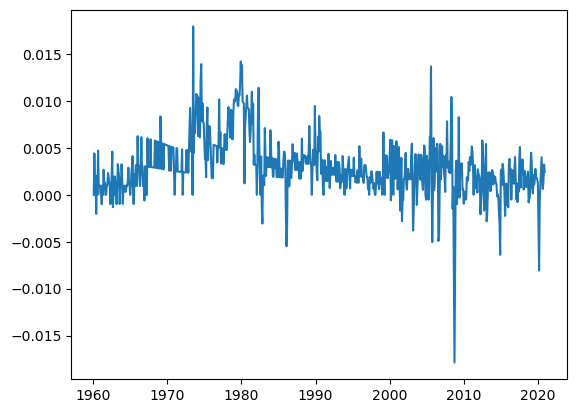

In [163]:
plt.plot(y['infl_tp1'])

In [169]:
'-'.join([str(i) for i in [32,32]])

'32-32'

In [161]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)

In [162]:
X_train = X_lags_ar.loc[:'1989-12-01']
for (train_ind, test_ind) in tscv.split(X_train):
    print('Train:', X_train.index[train_ind])
    print('Test:', X_train.index[test_ind])

Train: DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '1979-03-01', '1979-04-01', '1979-05-01', '1979-06-01',
               '1979-07-01', '1979-08-01', '1979-09-01', '1979-10-01',
               '1979-11-01', '1979-12-01'],
              dtype='datetime64[ns]', name='date', length=240, freq=None)
Test: DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01', '1980-11-01', '1980-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)
Train: DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '1980-03-01', '1980-0

# Volatility

In [2]:
targets = pd.read_csv('inflfc_targets.csv', index_col='date')

In [3]:
targets.head(50)

,infl_tp1,infl_tp2,infl_tp3,infl_tp4,infl_tp5,infl_tp6,infl_tp7,infl_tp8,infl_tp9,infl_tp10,infl_tp11,infl_tp12
date,,,,,,,,,,,,
1960-02-01,0.000000,0.004411,0.001015,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000
1960-03-01,0.004411,0.001015,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000
1960-04-01,0.001015,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006
1960-05-01,0.001352,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006
1960-06-01,-0.002028,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000
1960-07-01,0.002028,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000,0.002677
1960-08-01,0.000000,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000,0.002677,0.000668
1960-09-01,0.004717,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000,0.002677,0.000668,0.001335
1960-10-01,0.001008,0.001007,0.001006,0.000000,0.000000,-0.001006,0.001006,0.000000,0.002677,0.000668,0.001335,0.000000


In [4]:
vol = targets.std(axis=1)
vol

date
1960-02-01    0.001865
1960-03-01    0.001865
1960-04-01    0.001665
1960-05-01    0.001665
1960-06-01    0.001667
                ...   
2020-08-01    0.002464
2020-09-01    0.002393
2020-10-01    0.002368
2020-11-01    0.002125
2020-12-01    0.002000
Length: 729, dtype: float64

<AxesSubplot: xlabel='date'>

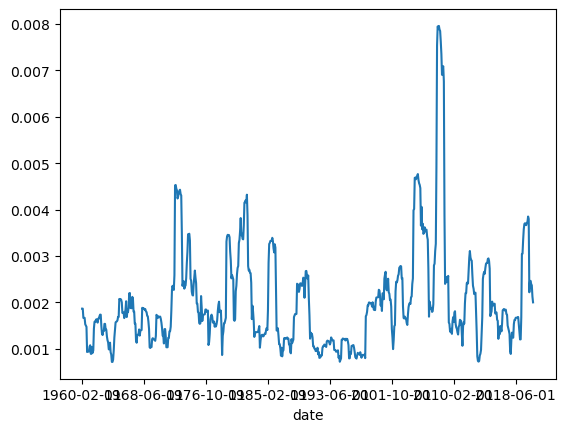

In [5]:
vol.plot()

In [10]:
delta_vol = vol - vol.shift(1)
delta_vol

date
1960-02-01             NaN
1960-03-01    0.000000e+00
1960-04-01   -2.004138e-04
1960-05-01   -1.267611e-07
1960-06-01    1.860961e-06
                  ...     
2020-08-01    1.468195e-05
2020-09-01   -7.073320e-05
2020-10-01   -2.547351e-05
2020-11-01   -2.428595e-04
2020-12-01   -1.245511e-04
Length: 729, dtype: float64

<AxesSubplot: xlabel='date'>

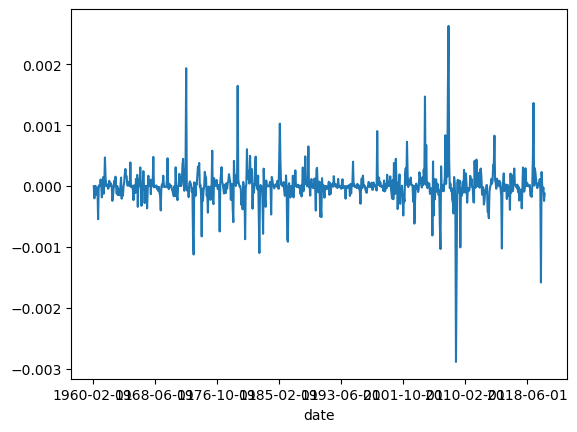

In [11]:
delta_vol.plot()

In [8]:
vol.to_frame().rename(columns={0:'volatility'}).to_csv('infl_volatility.csv')

In [12]:
delta_vol.to_frame().rename(columns={0:'delta_vol'}).to_csv('infl_delta_vol.csv')